In [1]:
import os, sys
import uproot
import awkward as ak
import ROOT as rt
import numpy as np
from array import array
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

Welcome to JupyROOT 6.26/04


In [2]:
energy = 100 # change this variable to select different energy files. Choose from [20,50,80,100,120,200,250,300]

inFile_HGC = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/skimmed_files/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/fullBL/v44_VtxBeam_v3_correctFH10_skimmed/FTFP_BERT_EMN/skimmed_ntuple_sim_config22_pion%dGeV_FTFP_BERT_EMN.root'%(energy)
file_HGC = uproot.open(inFile_HGC)
if(not file_HGC):
    print ("Could not open the file")
else:
    print ("%d GeV pion simulation file loaded successfully"%(energy))

100 GeV pion simulation file loaded successfully


In [3]:
tree = file_HGC['pion_variables']
if(not tree):
    print ('Could not open tree: pion_variables')
else:
    print ('Tree loaded successfully')

Tree loaded successfully


### Available branches in the ntulple 

In [4]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | uint32_t                 | AsDtype('>u4')
run                  | uint32_t                 | AsDtype('>u4')
pdgID                | int32_t                  | AsDtype('>i4')
beamEnergy           | float                    | AsDtype('>f4')
trueBeamEnergy       | float                    | AsDtype('>f4')
isHGC_AHC_sync       | bool                     | AsDtype('bool')
isGoodTrack          | bool                     | AsDtype('bool')
isFHNoisy            | bool                     | AsDtype('bool')
MuonVeto             | bool                     | AsDtype('bool')
isInTrackWindow      | bool                     | AsDtype('bool')
hgc_channel_mask     | std::vector<bool>        | AsJagged(AsDtype('bool'), h...
ahc_channel_mask     | std::vector<bool>        | AsJagged(AsDtype('bool'), h...
pass_noise_thres     

### Loading selected branches in the python dictionary format 

In [6]:
events = {
    'particle' : 'pi-'
}


branches = ['event','beamEnergy','isHGC_AHC_sync','isFHNoisy','MuonVeto','isInTrackWindow','hgc_channel_mask','ahc_channel_mask','pass_noise_thres',
            'NRechits','rechit_shower_start_layer',
            'rechit_energyPerLayer','ahc_energyPerLayer']

print ("Loading branches in the numpy format.")

for branch in tqdm(branches):
    events[branch] = tree[branch].array(library='np')

print ("Branches loaded successfully.")

Loading branches in the numpy format.


100%|██████████| 13/13 [00:15<00:00,  1.17s/it]

Branches loaded successfully.


### Adding separate columns for energy sum in CE-E, CE-H and AHCAL

In [7]:
# In terms of MIPs
events['rechit_energy_CE_E'] = np.asarray([np.sum(i[:28]) for i in events['rechit_energyPerLayer']])
events['rechit_energy_CE_H'] = np.asarray([np.sum(i[28:]) for i in events['rechit_energyPerLayer']])
events['rechit_energy_AHCAL'] = np.asarray([np.sum(i) for i in events['ahc_energyPerLayer']])

# In terms of GeV, using fixed weights
# CE-E: 0.0105 GeV per MIP --> Obtained using electron shower in CE-E
# CE-H: 0.0789 GeV per MIP --> Obtained using 50 GeV pion shower which are MIPs in CE-E
# AHCAL: 0.0316 GeV per MIP --> Obtained using 50 GeV pion shower which are MIPs in CE-E

events['gev_fixedCalib_CE_E'] = events['rechit_energy_CE_E']*0.0105
events['gev_fixedCalib_CE_H'] = events['rechit_energy_CE_H']*0.0789
events['gev_fixedCalib_AHCAL'] = events['rechit_energy_AHCAL']*0.0316

### chi2 weights in functional form

In [8]:
f_EH_w1 = rt.TF1("f_EH_w1","[0] + [1]/sqrt(x)", 5, 320)
f_EH_w1.FixParameter(0,1.05)
f_EH_w1.FixParameter(1,2.65)
f_EH_w2 = rt.TF1("f_EH_w2","[0] + [1]/sqrt(x)", 5, 320)
f_EH_w2.FixParameter(0,0.93)
f_EH_w2.FixParameter(1,1.49)
f_EH_w3 = rt.TF1("f_EH_w3","[0] + [1]/sqrt(x)", 5, 320)
f_EH_w3.FixParameter(0,0.96)
f_EH_w3.FixParameter(1,1.34)

f_H_w1 = rt.TF1("f_H_w1","[0]*x", 5, 320)
f_H_w1.FixParameter(0,0.0)
f_H_w2 = rt.TF1("f_H_w2","[0] + [1]/sqrt(x)", 5, 320)
f_H_w2.FixParameter(0,0.83)
f_H_w2.FixParameter(1,1.01)
f_H_w3 = rt.TF1("f_H_w3","[0] + [1]/sqrt(x)", 5, 320)
f_H_w3.FixParameter(0,0.94)
f_H_w3.FixParameter(1,0.92)

w1 = np.zeros(len(events['rechit_energy_CE_E']))
w2 = np.zeros(len(events['rechit_energy_CE_E']))
w3 = np.zeros(len(events['rechit_energy_CE_E']))

EE = events['rechit_shower_start_layer'] <= 28
FH = events['rechit_shower_start_layer'] > 28

w1[np.where(EE == True)] = f_EH_w1.Eval(energy)
w2[np.where(EE == True)] = f_EH_w2.Eval(energy)
w3[np.where(EE == True)] = f_EH_w3.Eval(energy)

w1[np.where(FH == True)] = 1.0
w2[np.where(FH == True)] = f_H_w2.Eval(energy)
w3[np.where(FH == True)] = f_H_w3.Eval(energy)

events['w1'] = w1
events['w2'] = w2
events['w3'] = w3


### Calculate energies in GeV for CE-E, CE-H, and AHCAL and add separate columns 

In [9]:
events['gev_chi2Calib_CE_E'] = events['gev_fixedCalib_CE_E']*events['w1']
events['gev_chi2Calib_CE_H'] = events['gev_fixedCalib_CE_H']*events['w2']
events['gev_chi2Calib_AHCAL'] = events['gev_fixedCalib_AHCAL']*events['w3']

### Define event-wise cuts to be used (channel wise cleaning cuts are already applied)

In [10]:
event_cleaning_cuts = events['isHGC_AHC_sync'] & ~events['isFHNoisy'] & ~events['MuonVeto'] & events['isInTrackWindow'] & (events['rechit_shower_start_layer'] > 2)
event_cleaning_cuts

array([ True,  True,  True, ...,  True,  True,  True])

### Plotting out of the box energy sums (in MIPs) in the calorimeter

Text(0.5, 1.0, '100 GeV pion, Energy deposited in CE-E+CE-H+AHCAL')

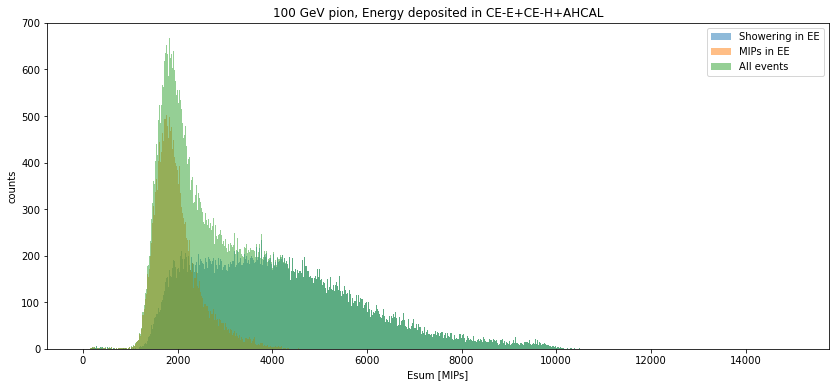

In [11]:
fig = plt.figure(figsize=(14.0,6.0))

Esum = events['rechit_energy_CE_E'] + events['rechit_energy_CE_H']+events['rechit_energy_AHCAL']

Esum_MIPs = Esum[event_cleaning_cuts]
Esum_MIPs_EE = Esum[event_cleaning_cuts & (events['rechit_shower_start_layer'] <= 28)]
Esum_MIPs_FH = Esum[event_cleaning_cuts & (events['rechit_shower_start_layer'] > 28)]


plt.hist(Esum_MIPs_EE,bins=1000, range=[0,15000], alpha=0.5,label='Showering in EE')
plt.hist(Esum_MIPs_FH,bins=1000, range=[0,15000], alpha=0.5,label='MIPs in EE')
plt.hist(Esum_MIPs,bins=1000, range=[0,15000], alpha=0.5,label='All events')
plt.xlabel('Esum [MIPs]')
plt.ylabel('counts')
plt.legend()
plt.title("%d GeV pion, Energy deposited in CE-E+CE-H+AHCAL"%(energy))

### Plotting energy deposited in the calorimeter using fixed weight

Text(0.5, 1.0, '100 GeV pion, Energy deposited in CE-E+CE-H+AHCAL : Fixed weights')

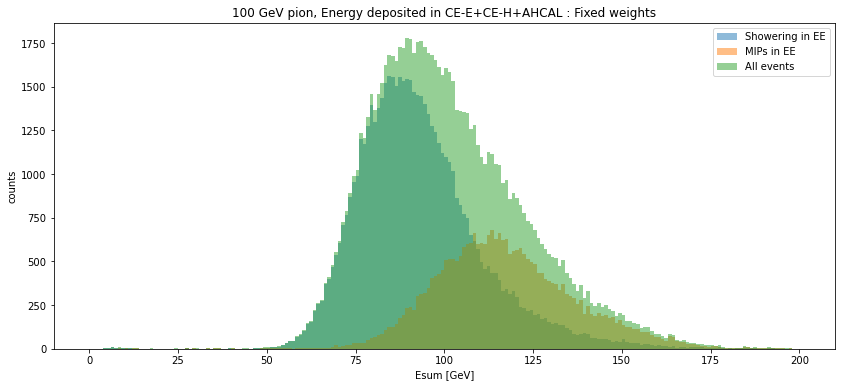

In [12]:
fig = plt.figure(figsize=(14.0,6.0))

# Esum_MIPs = np.sum(events['rechit_energy'][event_cleaning_cuts],axis=1)
# Esum_MIPs_EE = np.sum(events['rechit_energy'][event_cleaning_cuts & (events['rechit_shower_start_layer'] <= 28)],axis=1)
# Esum_MIPs_FH = np.sum(events['rechit_energy'][event_cleaning_cuts & (events['rechit_shower_start_layer'] > 28)],axis=1)
Esum_gev = events['gev_fixedCalib_CE_E']+ events['gev_fixedCalib_CE_H'] + events['gev_fixedCalib_AHCAL']

Esum_gev_all = Esum_gev[event_cleaning_cuts]
Esum_gev_EE = Esum_gev[event_cleaning_cuts & (events['rechit_shower_start_layer'] <= 28)]
Esum_gev_FH = Esum_gev[event_cleaning_cuts & (events['rechit_shower_start_layer'] > 28)]


plt.hist(Esum_gev_EE,bins=200, range=[0,200], alpha=0.5,label='Showering in EE')
plt.hist(Esum_gev_FH,bins=200, range=[0,200], alpha=0.5,label='MIPs in EE')
plt.hist(Esum_gev_all,bins=200, range=[0,200], alpha=0.5,label='All events')
plt.xlabel('Esum [GeV]')
plt.ylabel('counts')
plt.legend()
#plt.yscale('log', nonposy='clip')
plt.title("%d GeV pion, Energy deposited in CE-E+CE-H+AHCAL : Fixed weights"%(energy))
#plt.xlim(0,5)

### Plotting energy deposited in the calorimeter using chi2 weights

Text(0.5, 1.0, '100 GeV pion, Energy deposited in CE-E+CE-H+AHCAL : Chi2 weights')

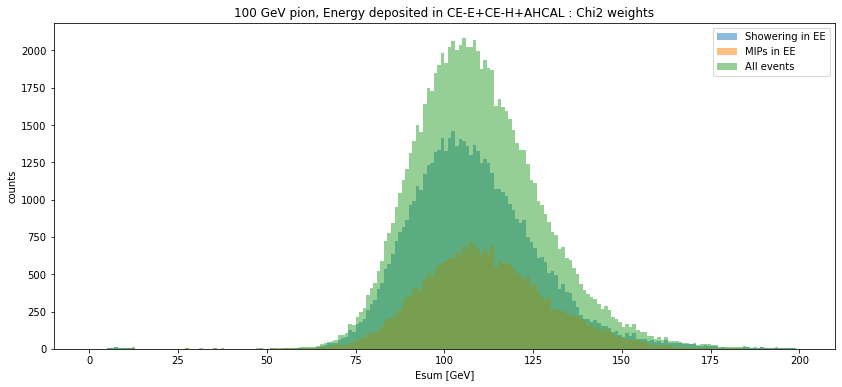

In [13]:
fig = plt.figure(figsize=(14.0,6.0))

Esum_gev = events['gev_chi2Calib_CE_E']+ events['gev_chi2Calib_CE_H'] + events['gev_chi2Calib_AHCAL']

Esum_gev_all = Esum_gev[event_cleaning_cuts]
Esum_gev_EE = Esum_gev[event_cleaning_cuts & (events['rechit_shower_start_layer'] <= 28)]
Esum_gev_FH = Esum_gev[event_cleaning_cuts & (events['rechit_shower_start_layer'] > 28)]


plt.hist(Esum_gev_EE,bins=200, range=[0,200], alpha=0.5,label='Showering in EE')
plt.hist(Esum_gev_FH,bins=200, range=[0,200], alpha=0.5,label='MIPs in EE')
plt.hist(Esum_gev_all,bins=200, range=[0,200], alpha=0.5,label='All events')
plt.xlabel('Esum [GeV]')
plt.ylabel('counts')
plt.legend()
plt.title("%d GeV pion, Energy deposited in CE-E+CE-H+AHCAL : Chi2 weights"%(energy))

### Plotting energy sharing between ECAL (CE-E) and HCAL (CE-H+AHCAL) on root canvas

100%|██████████| 86805/86805 [00:00<00:00, 680912.35it/s]


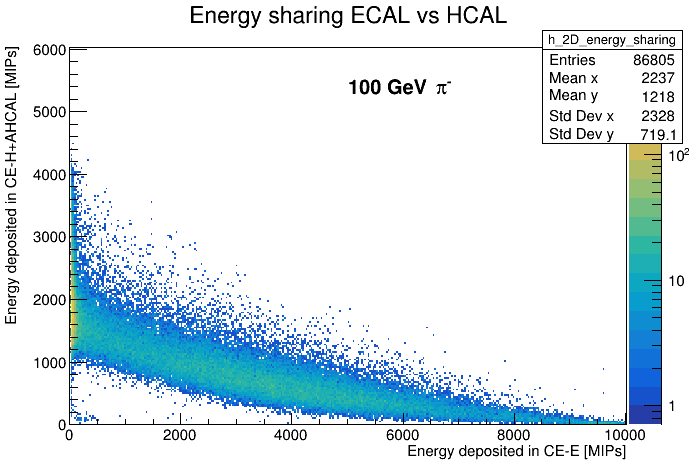

In [14]:
c=rt.TCanvas()
bins=500
xmin=-1
xmax=15000

h_2D_energy_sharing = rt.TH2F("h_2D_energy_sharing","Energy sharing ECAL vs HCAL",bins,xmin,xmax,bins,xmin,xmax)
h_2D_energy_sharing.GetXaxis().SetTitle("Energy deposited in CE-E [MIPs]")
h_2D_energy_sharing.GetYaxis().SetTitle("Energy deposited in CE-H+AHCAL [MIPs]")
ecal = events['rechit_energy_CE_E'][event_cleaning_cuts]
hcal = events['rechit_energy_CE_H'][event_cleaning_cuts] + events['rechit_energy_AHCAL'][event_cleaning_cuts]

for i in tqdm(range(len(ecal))):
    h_2D_energy_sharing.Fill(ecal[i],hcal[i])


h_2D_energy_sharing.Draw("colz")
h_2D_energy_sharing.GetYaxis().SetRangeUser(0,6000)
h_2D_energy_sharing.GetXaxis().SetRangeUser(0,10000)
rt.gPad.SetLogz()

textOnTop = rt.TLatex()
textOnTop.SetTextSize(0.045);
textOnTop.DrawLatexNDC(0.5,0.8,"%d GeV #pi^{-}"%(energy));

c.Draw()